Axis limits: 10^[(2.7781512503836434 -> -1.3979400086720375) x (3.845098040014257 ->-0.3979400086720376)] = 10^[4.176091259055681 x 4.243038048686294]
Plot logarithmic ratio: 0.9842219681128382

slope	"L1 Bandwidth"		7398.95 GB/s
slope	"L2 Bandwidth"		1237.34 GB/s
slope	"MCDRAM Bandwidth"		393.75 GB/s
slope	"DDR Bandwidth"		81.35 GB/s
roof	"Scalar Add Peak"		98.48 GFLOP/s
roof	"DP Vector Add Peak"		843.06 GFLOP/s
roof	"DP Vector FMA Peak"		1691.96 GFLOP/s
benchmark	"MyBWHungryBenchmark"		0.8 GFLOP/Byte
benchmark	"MyCPUIntensiveBenchmark"		30 GFLOP/Byte


ValueError: Automatic legend placement (loc='best') not implemented for figure legend

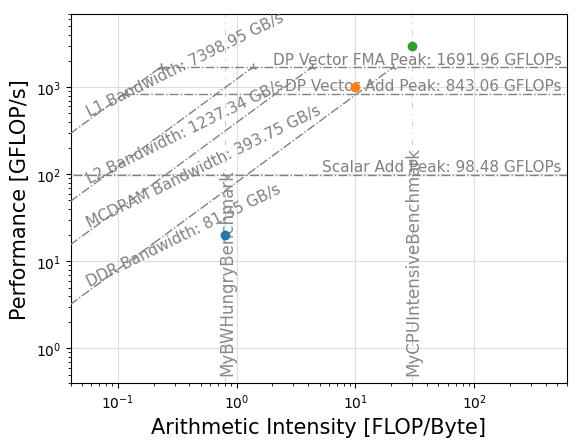

In [2]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.collections import PolyCollection
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib import colors as mcolors
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.ticker as ticker

import numpy as np
import sys
import pylab
import re
import json
import math

##########################################################
######################## Settings ########################
##########################################################

# Axis limits
xmin, xmax, ymin, ymax = 0.04, 600, 0.4, 7000
#xmin, xmax, ymin, ymax = 0.04, 20, 4, 2000
#xmin, xmax, ymin, ymax = 0.001, 10, 0.001, 1000

# Figure
fig_ratio = 2
fig_dimension = 7
fig = plt.figure()
ax = plt.subplot(1,1,1)
ax.grid(color="#dddddd", zorder=-1)
ax.set_xlabel("Arithmetic Intensity [FLOP/Byte]", fontsize=15)
ax.set_ylabel("Performance [GFLOP/s]", fontsize=15)

##########################################################
########################## Data ##########################
##########################################################

# Architecture-specific roofs
cpu_roofs = [
  {"name" : "Scalar Add Peak",    "val" : 98.48},
  {"name" : "DP Vector Add Peak", "val" : 843.06},
  {"name" : "DP Vector FMA Peak", "val" : 1691.96}
]
mem_bottlenecks = [
  {"name" : "L1 Bandwidth",     "val" : 7398.95},
  {"name" : "L2 Bandwidth",     "val" : 1237.34},
  {"name" : "MCDRAM Bandwidth", "val" : 393.75},
  {"name" : "DDR Bandwidth",    "val" : 81.35}
]

# Benchmarks
AI_v = {
  "MyBWHungryBenchmark" : 0.8,
  "MyCPUIntensiveBenchmark" : 30
}

# Datapoints
datapoints = [
  {"AI" : "MyBWHungryBenchmark",     "GFLOPs" : 20.00,  "label"  : "I'm lame",          "prop" : ["whatever", "..."]},
  {"AI" : 10,                        "GFLOPs" : 1000.00,  "label"  : "I'm pretty cool",  "prop" : ["whatever", "..."]},
  {"AI" : "MyCPUIntensiveBenchmark", "GFLOPs" : 3000.00, "label"  : "I'm unbelievable", "prop" : ["whatever", "..."]},
  
]

##########################################################
# set_size for explicitly setting axes widths/heights
# see: https://stackoverflow.com/a/44971177/5646732

def set_size(w,h, ax=None):
  """ w, h: width, height in inches """
  if not ax: ax=plt.gca()
  l = ax.figure.subplotpars.left
  r = ax.figure.subplotpars.right
  t = ax.figure.subplotpars.top
  b = ax.figure.subplotpars.bottom
  figw = float(w)/(r-l)
  figh = float(h)/(t-b)
  ax.figure.set_size_inches(figw, figh)

##########################################################

# Axis sizes
# In case of linear plotting you might need something like this: m = float(xmax-xmin)/(ymax-ymin)
#m = np.log(xmax-xmin)/np.log(ymax-ymin)
#mid_angle = np.arctan(m)/np.pi*180
xlogsize = float(np.log10(xmax/xmin))
ylogsize = float(np.log10(ymax/ymin))
m = xlogsize/ylogsize

print("Axis limits: 10^[(" + str(np.log10(xmax)) + " -> " + str(np.log10(xmin)) + ") x (" + str(np.log10(ymax)) + " ->" + str(np.log10(ymin)) + ")] = 10^[" + str(xlogsize) + " x " + str(ylogsize) + "]")
print("Plot logarithmic ratio: " + str(m) + "\n")
# START
max_roof  = cpu_roofs[0]["val"]
max_slope = mem_bottlenecks[0]["val"]

# Find maximum roof
for roof in cpu_roofs:
  if roof["val"] > max_roof:
    max_roof = roof["val"]

# Draw slopes
for slope in mem_bottlenecks:
  print("slope\t\"" + slope["name"] + "\"\t\t" + str(slope["val"]) + " GB/s",)

  y = [0, max_roof]
  x = [float(yy)/slope["val"] for yy in y]
  ax.loglog(x, y, linewidth=1.0,
    linestyle='-.',
    marker="2",
    color="grey",
    zorder=10)

  # Label
  xpos = xmin*(10**(xlogsize*0.04))
  ypos = xpos*slope["val"]
  if ypos<ymin:
    ypos = ymin*(10**(ylogsize*0.02))
    xpos = ypos/slope["val"]
  pos = (xpos, ypos)

  # In case of linear plotting you might need something like this: trans_angle = np.arctan(slope["val"]*m)*180/np.pi
  #trans_angle = 45*m
  # print "\t" + str(trans_angle) + "°"
  
  ax.annotate(slope["name"] + ": " + str(slope["val"]) + " GB/s", pos,
    rotation=np.arctan(m/fig_ratio)*180/np.pi, rotation_mode='anchor',
    fontsize=11,
    ha="left", va='bottom',
    color="grey")
    
  # In the meantime: find maximum slope
  if slope["val"] > max_slope:
    max_slope = slope["val"]

print

# Draw roofs
for roof in cpu_roofs:
  print("roof\t\"" + roof["name"] + "\"\t\t" + str(roof["val"]) + " GFLOP/s")

  x = [roof["val"]/max_slope, xmax*10]
  ax.loglog(x, [roof["val"] for xx in x], linewidth=1.0,
    linestyle='-.',
    marker="2",
    color="grey",
    zorder=10)

  # Label
  ax.text(
    #roof["val"]/max_slope*10,roof["val"]*1.1,
    xmax/(10**(xlogsize*0.01)), roof["val"]*(10**(ylogsize*0.01)),
    roof["name"] + ": " + str(roof["val"]) + " GFLOPs",
    ha="right",
    fontsize=11,
    color="grey")

print

#plt.xticks(list(plt.xticks()[0]) + [AI for n,AI in AI_v.items()], list(plt.xticks()[0]) + [str(AI) for n,AI in AI_v.items()])
for benchmark in AI_v:
  AI = AI_v[benchmark]
  print("benchmark\t\"" + benchmark + "\"\t\t" + str(AI) + " GFLOP/Byte")

  plt.axvline(x=AI, dashes=[10, 10, 3, 10], linewidth=0.4, color="#aaaaaa")

  ax.text(
    AI/1.15, ymin*1.24,
    benchmark,
    fontsize=12,
    rotation=90,
    va="bottom",
    color="#888888")

# Draws datapoints
for point in datapoints:
  AI = point["AI"]
  if isinstance(AI,str):
    AI = AI_v[AI]

  ax.scatter(AI, point["GFLOPs"], label=point["label"], zorder=100)

# Logarithmic axis labels format
#ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y,pos: ('{{:.{:1d}f}}'.format(int(np.maximum(-np.log10(y),0)))).format(y)))
#ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda y,pos: ('{{:.{:1d}f}}'.format(int(np.maximum(-np.log10(y),0)))).format(y)))

# Set aspect
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)

plt.figlegend(loc="best")
plt.title("Rooflini example", fontsize=20)
plt.tight_layout()
set_size(fig_dimension*fig_ratio,fig_dimension)
plt.show()
